In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style, rcParams
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import xgboost.sklearn as xgb
import gensim
import seaborn as sns
import pickle

style.use('ggplot')
rcParams['font.size'] = 14
rcParams['legend.fontsize'] = 'small'
rcParams['figure.titlesize'] = 'large'

In [2]:
df = pd.read_csv('../data/train.csv')

In [3]:
df_5class = df[df['Labels'] != 4].copy()

(9401, 3)

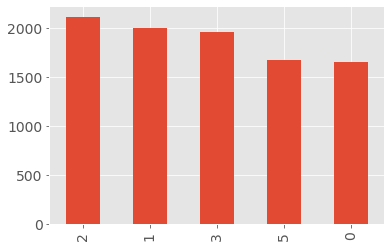

In [6]:
df_5class.Labels.value_counts().plot(kind='bar');
df_5class.shape
# Half-True - 2
# False - 1
# Mostly-True - 3
# True - 5
# Barely-True - 0
# Not-Known - 4

In [7]:
X = df_5class['Text']
y = df_5class['Labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
stopwords_ = set(stopwords.words('english'))

In [9]:
tfidf = TfidfVectorizer(stop_words=stopwords_)
words_train = tfidf.fit_transform(X_train).toarray()
words_test = tfidf.transform(X_test).toarray()
feats = tfidf.get_feature_names()

In [10]:
words_train.shape, words_test.shape

((7520, 10337), (1881, 10337))

In [11]:
pca = PCA()
pca.fit(words_train)

PCA()

In [12]:
filename = '../models/pca_model_5classes.sav'
pickle.dump(pca, open(filename, 'wb'))

In [13]:
words_tr_pca = pca.transform(words_train)
words_tst_pca = pca.transform(words_test)

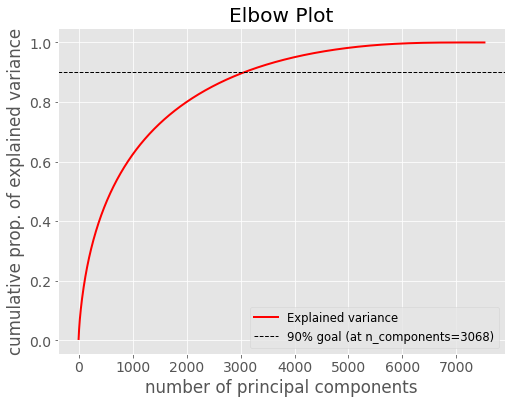

In [14]:
total_variance = np.sum(pca.explained_variance_)
cum_variance = np.cumsum(pca.explained_variance_)
prop_var_expl = cum_variance/total_variance
idx = np.argwhere(prop_var_expl > 0.9)[0][0] + 1

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl, color='red', linewidth=2, label='Explained variance')
ax.axhline(0.9, label=f'90% goal (at n_components={idx})', linestyle='--', color="black", linewidth=1)
ax.set_ylabel('cumulative prop. of explained variance')
ax.set_xlabel('number of principal components')
ax.set_title('Elbow Plot')
ax.legend()
plt.savefig('../images/pca5c_cumulsum_elbow.png');

In [15]:
np.argwhere(prop_var_expl > 0.9)[0][0]

3067

In [32]:
prop_var_expl[3262]

0.9000272792363343

In [70]:
words.shape

(10240, 12061)

In [21]:
comp = 3068
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(words_tr_pca[:,:comp], y_train)
y_pred = rf.predict(words_tst_pca[:,:comp])

In [61]:
filename = '../models/rf2_5classes.sav'
pickle.dump(rf, open(filename, 'wb'))

In [22]:
# print(f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(classification_report(y_train, rf.predict(words_tr_pca[:,:comp])))
rf.score(words_tr_pca[:,:comp], y_train)

              precision    recall  f1-score   support

           0       0.16      0.06      0.09       331
           1       0.23      0.30      0.26       399
           2       0.23      0.38      0.29       423
           3       0.25      0.25      0.25       393
           5       0.15      0.05      0.08       335

    accuracy                           0.22      1881
   macro avg       0.20      0.21      0.19      1881
weighted avg       0.21      0.22      0.20      1881

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1323
           1       1.00      1.00      1.00      1596
           2       1.00      1.00      1.00      1691
           3       1.00      1.00      1.00      1569
           5       1.00      1.00      1.00      1341

    accuracy                           1.00      7520
   macro avg       1.00      1.00      1.00      7520
weighted avg       1.00      1.00      1.00      7520



0.999468085106383

In [23]:
confusion_matrix(y_test, y_pred)

array([[ 21,  90, 143,  59,  18],
       [ 33, 120, 146,  78,  22],
       [ 28, 118, 162,  96,  19],
       [ 28,  96, 132, 100,  37],
       [ 25,  98, 127,  68,  17]])

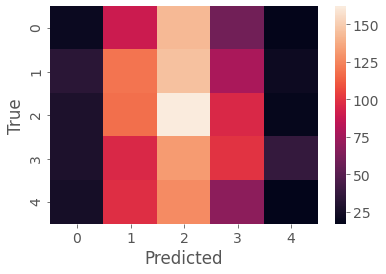

In [25]:
sns.heatmap(confusion_matrix(y_test, y_pred))
plt.xlabel('Predicted')
plt.ylabel('True');

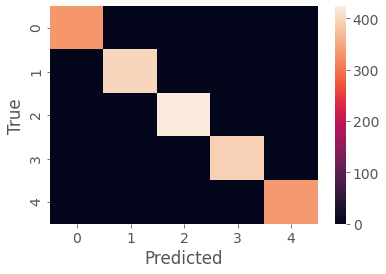

In [26]:
# if it were a perfect prediction

sns.heatmap(confusion_matrix(y_test, y_test))
plt.xlabel('Predicted')
plt.ylabel('True');

Try dropping the not known class (class 4) and rerun